In [2]:
# Import necessary libraries
import pandas as pd

# Load the dataset
file_path = '/content/sample_data/karthik_asadi_data.xlsx'  # Path to your dataset
df = pd.read_excel(file_path)

# Display the first few rows
print(df.head())


           ID              Name              Role  \
0  candidate1   Johnny Lawrence       UI Engineer   
1  candidate2  Michelle Bradley    Data Scientist   
2  candidate3      John Harrell     Data Engineer   
3  candidate4        Erik Walls  Business Analyst   
4  candidate5     Jeremy Powell  Business Analyst   

                                          Transcript  \
0  Interviewer: Can you explain JavaScript?\nCand...   
1  Interviewer: Can you explain Machine Learning?...   
2  Interviewer: Can you explain Big Data?\nCandid...   
3  Interviewer: Can you explain Stakeholder Commu...   
4  Interviewer: Can you explain Requirement Gathe...   

                                              Resume  \
0  Name: Johnny Lawrence\nRole: UI Engineer\nExpe...   
1  Name: Michelle Bradley\nRole: Data Scientist\n...   
2  Name: John Harrell\nRole: Data Engineer\nExper...   
3  Name: Erik Walls\nRole: Business Analyst\nExpe...   
4  Name: Jeremy Powell\nRole: Business Analyst\nE...   

  Perfo

**Data cleaning **

In [3]:
import re

# Cleaning function
def clean_text(text):
    if isinstance(text, str):
        return re.sub(r'\W+', ' ', text).lower()
    return ""

# Apply cleaning
df['Transcript'] = df['Transcript'].apply(clean_text)
df['Resume'] = df['Resume'].apply(clean_text)
df['Job Description'] = df['Job Description'].apply(clean_text)


# **Feature Engineering**
**3.1: Resume and JD Similarity**
Calculate the cosine similarity between Resume and Job Description using TF-IDF.

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf = TfidfVectorizer()

# Vectorize Resume and JD
jd_vector = tfidf.fit_transform(df['Job Description'])
resume_vector = tfidf.transform(df['Resume'])

# Calculate similarity
df['jd_resume_similarity'] = [cosine_similarity(jd, rv).flatten()[0] for jd, rv in zip(jd_vector, resume_vector)]


**3.2: Transcript and Resume Similarity**

In [5]:
# Vectorize Transcript
transcript_vector = tfidf.transform(df['Transcript'])

# Calculate similarity
df['transcript_resume_similarity'] = [cosine_similarity(tv, rv).flatten()[0] for tv, rv in zip(transcript_vector, resume_vector)]


**3.3: Sentiment Analysis and Transcript Length**
Use TextBlob to extract sentiment polarity and compute the length of the transcript.

In [6]:
from textblob import TextBlob

# Sentiment analysis
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['transcript_sentiment'] = df['Transcript'].apply(get_sentiment)

# Transcript length
df['transcript_length'] = df['Transcript'].apply(len)


**3.4: Encode Target Variable**

In [7]:
# Encode select/reject as 1/0
df['target'] = df['Performance (select/reject)'].map({'Selected': 1, 'Rejected': 0})


# **Split Dataset**
Split the dataset into training (80%) and testing (20%) sets.

In [12]:
from sklearn.model_selection import train_test_split

# Features (X) and Target (y)
X = df[['jd_resume_similarity', 'transcript_resume_similarity', 'transcript_sentiment', 'transcript_length']]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (400, 4)
Testing set shape: (100, 4)


# **Train Models**
Train the models listed (Logistic Regression, Decision Tree, Random Forest, XGBoost) and evaluate them.

**Logistic Regression**

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

lr_acc = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred)
print(f"Logistic Regression - Accuracy: {lr_acc}, AUC: {lr_auc}")


Logistic Regression - Accuracy: 0.87, AUC: 0.8717532467532467


**Decision Tree**

In [14]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

dt_acc = accuracy_score(y_test, dt_pred)
dt_auc = roc_auc_score(y_test, dt_pred)
print(f"Decision Tree - Accuracy: {dt_acc}, AUC: {dt_auc}")


Decision Tree - Accuracy: 0.78, AUC: 0.7816558441558441


**Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred)
print(f"Random Forest - Accuracy: {rf_acc}, AUC: {rf_auc}")


Random Forest - Accuracy: 0.86, AUC: 0.8530844155844155


**XGBoost**

In [17]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=42, eval_metric='logloss')
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred)
print(f"XGBoost - Accuracy: {xgb_acc}, AUC: {xgb_auc}")


XGBoost - Accuracy: 0.82, AUC: 0.8173701298701299


# **Model Comparison**
Compile results into a dataframe for easier comparison.

In [18]:
model_performance = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_acc, dt_acc, rf_acc, xgb_acc],
    'ROC_AUC': [lr_auc, dt_auc, rf_auc, xgb_auc]
})

print(model_performance.sort_values(by='Accuracy', ascending=False))


                 Model  Accuracy   ROC_AUC
0  Logistic Regression      0.87  0.871753
2        Random Forest      0.86  0.853084
3              XGBoost      0.82  0.817370
1        Decision Tree      0.78  0.781656


# **Hyperparameter Tuning**
Use GridSearchCV to optimize model parameters for Random Forest and XGBoost.

**for Random Forest Tuning**

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 10]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
best_rf_pred = best_rf.predict(X_test)
print(f"Tuned Random Forest - AUC: {roc_auc_score(y_test, best_rf_pred)}")


Tuned Random Forest - AUC: 0.8506493506493507


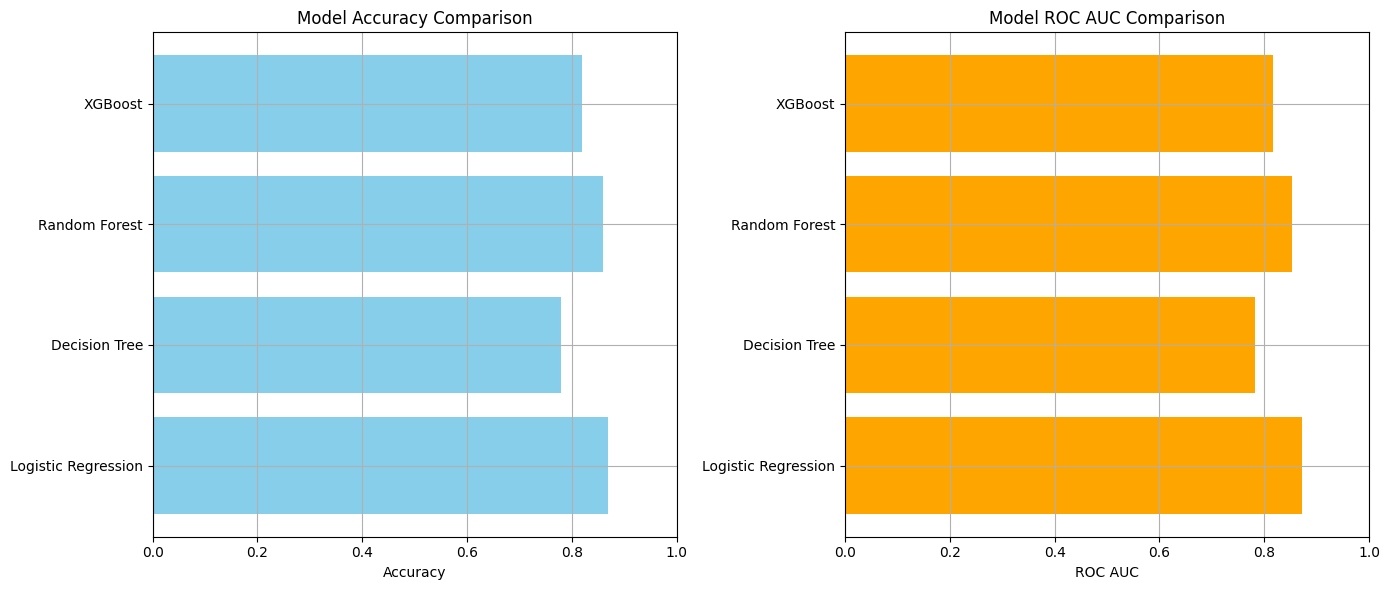

In [22]:
import matplotlib.pyplot as plt

# Collect results from models
results = {
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_acc, dt_acc, rf_acc, xgb_acc],
    'ROC_AUC': [lr_auc, dt_auc, rf_auc, xgb_auc]
}

# Convert to DataFrame for analysis
model_comparison = pd.DataFrame(results)

# Plot comparison
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy bar plot
ax[0].barh(model_comparison['Model'], model_comparison['Accuracy'], color='skyblue')
ax[0].set_title('Model Accuracy Comparison')
ax[0].set_xlabel('Accuracy')
ax[0].set_xlim(0, 1)
ax[0].grid(True)

# ROC AUC bar plot
ax[1].barh(model_comparison['Model'], model_comparison['ROC_AUC'], color='orange')
ax[1].set_title('Model ROC AUC Comparison')
ax[1].set_xlabel('ROC AUC')
ax[1].set_xlim(0, 1)
ax[1].grid(True)

plt.tight_layout()
plt.show()


# **Visualize the ROC Curves of All Models**

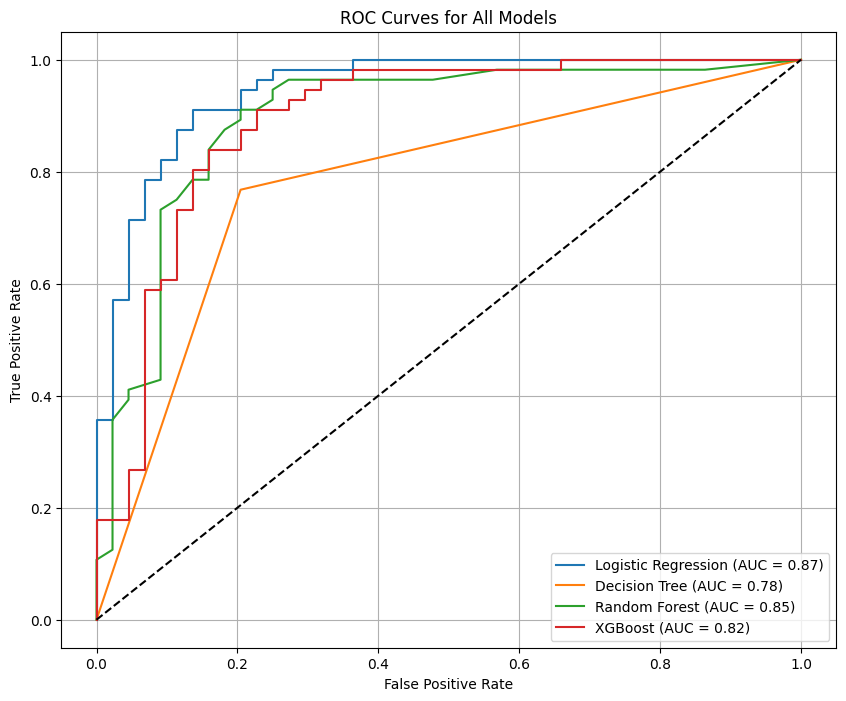

In [23]:
# Logistic Regression ROC
lr_prob = lr.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_prob)

# Decision Tree ROC
dt_prob = dt.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_prob)

# Random Forest ROC
rf_prob = rf.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_prob)

# XGBoost ROC
xgb_prob = xgb.predict_proba(X_test)[:, 1]
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_prob)

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()




Based on the Accuracy and AUC values, identify the best model:

In [24]:
# Identify the best model
best_model = model_comparison.loc[model_comparison['Accuracy'].idxmax()]
print(f"The best model is {best_model['Model']} with Accuracy: {best_model['Accuracy']:.2f} and AUC: {best_model['ROC_AUC']:.2f}")


The best model is Logistic Regression with Accuracy: 0.87 and AUC: 0.87


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
import joblib

# Training Phase: Save the state
lr = LogisticRegression()
lr.fit(X_train, y_train)
joblib.dump(lr, 'logistic_regression_model.pkl')  # Save the model
print("Logistic Regression model saved!")

# Prediction Phase: Load the state
loaded_lr = joblib.load('logistic_regression_model.pkl')  # Load the model
lr_pred = loaded_lr.predict(X_test)

# Evaluate the model
lr_acc = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred)
print(f"Loaded Logistic Regression - Accuracy: {lr_acc:.2f}, AUC: {lr_auc:.2f}")


Logistic Regression model saved!
Loaded Logistic Regression - Accuracy: 0.87, AUC: 0.87


In [28]:
# Combine metrics into a DataFrame
performance_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Decision Tree", "Random Forest", "XGBoost"],
    "Accuracy": [lr_metrics["Accuracy"], dt_metrics["Accuracy"], rf_metrics["Accuracy"], xgb_metrics["Accuracy"]],
    "Precision": [lr_metrics["Precision"], dt_metrics["Precision"], rf_metrics["Precision"], xgb_metrics["Precision"]],
    "Recall": [lr_metrics["Recall"], dt_metrics["Recall"], rf_metrics["Recall"], xgb_metrics["Recall"]],
    "F1-Score": [lr_metrics["F1-Score"], dt_metrics["F1-Score"], rf_metrics["F1-Score"], xgb_metrics["F1-Score"]],
    "AUC": [lr_metrics["AUC"], dt_metrics["AUC"], rf_metrics["AUC"], xgb_metrics["AUC"]]
})

# Sort the table by Accuracy (or any other metric)
performance_df = performance_df.sort_values(by="Accuracy", ascending=False)

# Print the table
print(performance_df)


                 Model  Accuracy  Precision    Recall  F1-Score       AUC
0  Logistic Regression      0.87   0.905660  0.857143  0.880734  0.871753
2        Random Forest      0.86   0.850000  0.910714  0.879310  0.853084
3              XGBoost      0.82   0.839286  0.839286  0.839286  0.817370
1        Decision Tree      0.78   0.826923  0.767857  0.796296  0.781656
